In [54]:
# importing Required Libraries and Load Data set

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [55]:
# importing the data set
try:
    df = pd.read_csv("Raw_Data/train.csv")
except:
    df = pd.read_csv("train.csv")

# display the first five row of the dataframe
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [56]:

# data preprocessing and feature engineering
# defining the target variable and feature set

target = "accident_risk"



In [57]:
# separate x and y

X = df.drop(columns=[target])
y = df[target]

In [58]:
numerical_features = [
    "num_lanes",
    "curvature",
    "speed_limit",
    "num_reported_accidents"
]

categorical_features = [
    "road_type",
    "lighting",
    "weather",
    "time_of_day"
]

boolean_features = [
    "road_signs_present",
    "public_road",
    "holiday",
    "school_season"
]

id_column = "id"

In [59]:
# handling the id columns since it is important for the submission.csv file
X_ids = X[id_column]
X = X.drop(columns=[id_column])

In [60]:
# dealing with boolean ctegories
# converting boolean features to intergers as 0 and 1 represent False and True respectively
X[boolean_features] = X[boolean_features].astype(int)

🧾 Preprocessing Summary (Notebook-Ready)

“After EDA, preprocessing involved separating the target variable, excluding identifiers from training features, converting boolean flags to numeric format, and explicitly categorizing numerical and categorical variables. A train–validation split was applied to support robust model evaluation while preserving Kaggle submission requirements.”

In [61]:
df["speed_risk_band"] = pd.cut(
    df["speed_limit"],
    bins=[0, 30, 50, 70, 100],
    labels=["very_low", "low", "medium", "high"]
)


In [62]:
df["speed_risk_band"].value_counts()


speed_risk_band
low         227380
medium      188952
very_low    101422
high             0
Name: count, dtype: int64

In [63]:
df["high_curvature"] = (df["curvature"] > 0.6).astype(int)

In [64]:
df["lane_complexity"] = df["num_lanes"] * df["curvature"]

In [65]:
df["accident_density"] = df['num_reported_accidents'] / (df['num_lanes'] + 1)

In [66]:
df["poor_visibility"] = df["weather"].isin(["fog", "rain"]).astype(int)

In [67]:
numerical_features = [
    "num_lanes",
    "curvature",
    "speed_limit",
    "lane_complexity"      # SAFE
]

categorical_features = [
    "road_type",
    "lighting",
    "weather",
    "time_of_day",
    "speed_risk_band"      # SAFE engineered category
]


boolean_features = [
    "road_signs_present",
    "public_road",
    "holiday",
    "school_season",
    "high_curvature",      # SAFE
    "poor_visibility"      # SAFE
]



In [68]:
df[["num_reported_accidents", "num_lanes", "accident_density"]].head()


,num_reported_accidents,num_lanes,accident_density
0,1,2,0.333333
1,0,4,0.000000
2,2,4,0.400000
3,1,4,0.200000
4,1,1,0.500000


In [69]:
df[["num_reported_accidents", "accident_risk"]].corr()


,num_reported_accidents,accident_risk
num_reported_accidents,1.000000,0.213891
accident_risk,0.213891,1.000000


In [70]:

features = numerical_features + categorical_features + boolean_features


In [71]:
# preparing training data
x = df[features]
y = df['accident_risk']

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
X, y, test_size=0.2, random_state=42
)



In [73]:

cat_features_idx = [
    X_train.columns.get_loc(col)
    for col in categorical_features
    if col in X_train.columns
]

In [74]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=600,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100
)


In [75]:
# train catboost
cat_model.fit(
    X_train,
    y_train,
    cat_features=cat_features_idx,
    eval_set=(X_val, y_val),
    use_best_model=True
)


0:	learn: 0.1592976	test: 0.1590170	best: 0.1590170 (0)	total: 711ms	remaining: 7m 5s
100:	learn: 0.0564315	test: 0.0566909	best: 0.0566909 (100)	total: 60s	remaining: 4m 56s


KeyboardInterrupt: 

In [ ]:
# predict a validation set
y_val_pred = cat_model.predict(X_val)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse

np.float64(0.05629405370962316)

In [ ]:
#sanity check
y_val_pred.min(), y_val_pred.max()

(np.float64(0.026136709402837077), np.float64(0.8716666564630273))

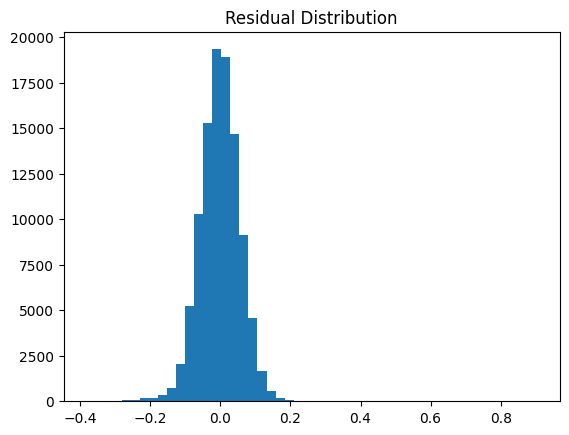

In [ ]:
# residual distribution

residuals = y_val - y_val_pred

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()


In [ ]:
#feature importance and pruning
# extract feature importance from catboost
feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": cat_model.get_feature_importance()
}).sort_values(by="importance", ascending=False)

feature_importances

,feature,importance
3,speed_limit,39.959277
4,lighting,36.559686
5,weather,9.798073
2,curvature,9.797284
11,num_reported_accidents,3.702069
9,holiday,0.059671
7,public_road,0.043221
1,num_lanes,0.036944
6,road_signs_present,0.016235
8,time_of_day,0.011633


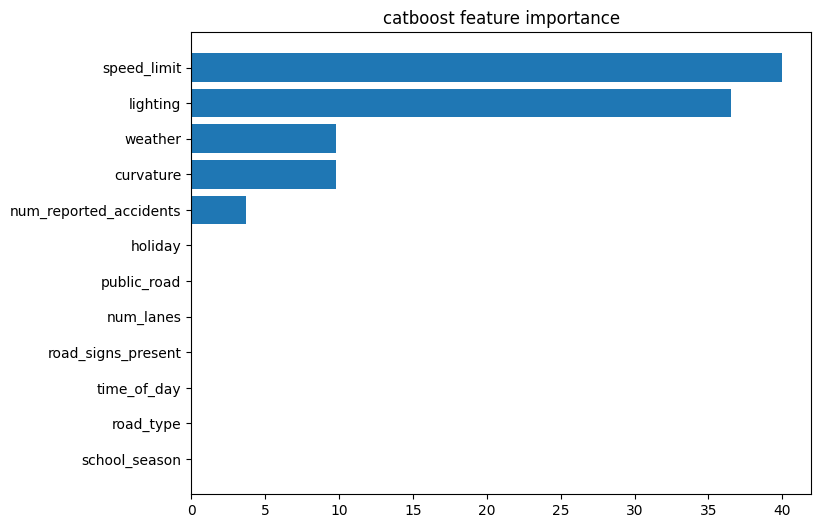

In [ ]:
# visualize the feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importances['feature'],
    feature_importances['importance']
)
plt.gca().invert_yaxis()
plt.title("catboost feature importance")
plt.show()

In [ ]:
# identify the weak features
weak_features = feature_importances[
    feature_importances['importance'] < 1.0
]['feature'].tolist()

weak_features

['holiday',
 'public_road',
 'num_lanes',
 'road_signs_present',
 'time_of_day',
 'road_type',
 'school_season']

In [ ]:
features_pruned = [
    f for f in X_train.columns if f not in weak_features
]


In [ ]:
features_pruned

['curvature', 'speed_limit', 'lighting', 'weather', 'num_reported_accidents']

In [ ]:
# retraining the model after pruning
X_train_p = X_train[features_pruned]
X_val_p = X_val[features_pruned]


In [ ]:
# recompute categoricl features
cat_features_idx_p = [
    X_train_p.columns.get_loc(col)
    for col in categorical_features
    if col in X_train_p.columns
]


In [ ]:
# train again
cat_model_pruned = CatBoostRegressor(
    iterations=600,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100
)

cat_model_pruned.fit(
    X_train_p,
    y_train,
    cat_features=cat_features_idx_p,
    eval_set=(X_val_p, y_val),
    use_best_model=True
)


0:	learn: 0.1592568	test: 0.1589786	best: 0.1589786 (0)	total: 375ms	remaining: 3m 44s
100:	learn: 0.0565162	test: 0.0567387	best: 0.0567387 (100)	total: 26.2s	remaining: 2m 9s
200:	learn: 0.0563432	test: 0.0566085	best: 0.0566085 (200)	total: 46.3s	remaining: 1m 31s
300:	learn: 0.0562212	test: 0.0565246	best: 0.0565246 (300)	total: 1m 8s	remaining: 1m 8s
400:	learn: 0.0561328	test: 0.0564567	best: 0.0564567 (400)	total: 1m 33s	remaining: 46.2s
500:	learn: 0.0560666	test: 0.0564168	best: 0.0564168 (500)	total: 1m 58s	remaining: 23.4s
599:	learn: 0.0560107	test: 0.0563900	best: 0.0563899 (598)	total: 2m 23s	remaining: 0us

bestTest = 0.056389854
bestIteration = 598

Shrink model to first 599 iterations.


In [ ]:
# reevaluate rmse
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred_p = cat_model_pruned.predict(X_val_p)
rmse_pruned = np.sqrt(mean_squared_error(y_val, y_val_pred_p))

rmse_pruned


np.float64(0.056389854298230326)

In [ ]:
#Hyperparameter tuning
# focused hyperparmeter tuning for catboostregressor

X_train_t = X_train[features_pruned]
X_val_t = X_val[features_pruned]

cat_features_idx_t = [
    X_train_t.columns.get_loc(col)
    for col in categorical_features
    if col in X_train_t.columns
]


In [ ]:
model_1 = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=5,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)


In [ ]:

model_2 = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=7,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)



In [ ]:
model_3 = CatBoostRegressor(
    iterations=800,
    learning_rate=0.07,
    depth=6,
    l2_leaf_reg=3,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)


In [ ]:
# train and evaluate each model

from sklearn.metrics import mean_squared_error
import numpy as np

models = {
    "balanced": model_1,
    "deep": model_2,
    "shallow": model_3
}

results = {}

for name, model in models.items():
    model.fit(
        X_train_t,
        y_train,
        cat_features=cat_features_idx_t,
        eval_set=(X_val_t, y_val),
        use_best_model=True
    )
    
    preds = model.predict(X_val_t)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    
    results[name] = rmse
    print(f"{name} RMSE: {rmse}")


0:	learn: 0.1592614	test: 0.1589831	best: 0.1589831 (0)	total: 405ms	remaining: 6m 44s
100:	learn: 0.0565127	test: 0.0567362	best: 0.0567362 (100)	total: 26.3s	remaining: 3m 54s
200:	learn: 0.0563442	test: 0.0566105	best: 0.0566105 (200)	total: 46.3s	remaining: 3m 4s
300:	learn: 0.0562524	test: 0.0565436	best: 0.0565436 (300)	total: 1m 5s	remaining: 2m 32s
400:	learn: 0.0561768	test: 0.0564827	best: 0.0564827 (400)	total: 1m 33s	remaining: 2m 19s
500:	learn: 0.0561040	test: 0.0564359	best: 0.0564359 (500)	total: 2m 11s	remaining: 2m 10s
600:	learn: 0.0560503	test: 0.0564037	best: 0.0564037 (600)	total: 2m 40s	remaining: 1m 46s
700:	learn: 0.0560008	test: 0.0563754	best: 0.0563754 (700)	total: 3m 12s	remaining: 1m 22s
800:	learn: 0.0559627	test: 0.0563597	best: 0.0563597 (800)	total: 3m 43s	remaining: 55.6s
900:	learn: 0.0559279	test: 0.0563479	best: 0.0563479 (900)	total: 4m 14s	remaining: 27.9s
999:	learn: 0.0558954	test: 0.0563369	best: 0.0563369 (999)	total: 4m 45s	remaining: 0us

b

In [ ]:
results

{'balanced': np.float64(0.05633686389606636),
 'deep': np.float64(0.05633490313094228),
 'shallow': np.float64(0.056395944742846336)}

In [ ]:
# note the deep model performed the best with the lowest RSME
best_model = model_2
best_model.get_evals_result()


{'learn': {'RMSE': [0.16213333103960298,
   0.15793111205167898,
   0.15389045485132835,
   0.1499701042979188,
   0.14620177418811187,
   0.14253406583103398,
   0.13900464317966377,
   0.13561159133550546,
   0.1323382786580577,
   0.1291864332665888,
   0.12614474755058236,
   0.1231863952583836,
   0.12033394829468576,
   0.11758501186390038,
   0.11494687781641208,
   0.11237955217933292,
   0.10991271822816663,
   0.10755064353586263,
   0.10527323537472895,
   0.10308774194382031,
   0.10100282119824339,
   0.09897173256795672,
   0.09702821451224569,
   0.09514458245186114,
   0.0933349567005453,
   0.09160607715360303,
   0.08994425461872337,
   0.08836854469717464,
   0.086852501710013,
   0.08540690121520002,
   0.0840286157378889,
   0.08269270109929744,
   0.08143210448939195,
   0.08021791256098419,
   0.07904461778873242,
   0.07792451020301304,
   0.07685826592833095,
   0.07583802554897218,
   0.07487620919363862,
   0.07396278941884152,
   0.07306995855693214,
   0.07

In [ ]:
# train full model and genrate kaggle submission file
X_full = df[features_pruned]
y_full = df["accident_risk"]


In [ ]:
# recompute categorical indices
cat_features_idx_full = [
    X_full.columns.get_loc(col)
    for col in categorical_features
    if col in X_full.columns
]


In [ ]:
# reinializing the best model which is the deep model since it has the lowest rmse
from catboost import CatBoostRegressor

final_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=7,
    loss_function="RMSE",
    random_seed=42,
    verbose=200
)


In [ ]:
#train on full dataset
final_model.fit(
    X_full,
    y_full,
    cat_features=cat_features_idx_full
)


0:	learn: 0.1620859	total: 367ms	remaining: 9m 9s
200:	learn: 0.0563569	total: 1m 32s	remaining: 9m 59s
400:	learn: 0.0562282	total: 2m 50s	remaining: 7m 48s
600:	learn: 0.0560949	total: 3m 51s	remaining: 5m 46s
800:	learn: 0.0560167	total: 5m 3s	remaining: 4m 24s
1000:	learn: 0.0559523	total: 6m 23s	remaining: 3m 11s
1200:	learn: 0.0559068	total: 7m 39s	remaining: 1m 54s
1400:	learn: 0.0558663	total: 8m 55s	remaining: 37.8s
1499:	learn: 0.0558475	total: 9m 36s	remaining: 0us


In [ ]:
# preparing test data
try:
    test_df = pd.read_csv('Raw_Data/test.csv')
except:
    test_df = pd.read_csv("test.csv")
    


In [ ]:
"""numerical_features = [
"num_lanes",
"curvature",
"speed_limit",
"lane_complexity"
]

categorical_features = [
"road_type",
"lighting",
"weather",
"time_of_day",
"speed_risk_band"
]

boolean_features = [
"road_signs_present",
"public_road",
"holiday",
"school_season",
"high_curvature",
"poor_visibility"
]

features = numerical_features + categorical_features + boolean_features"""

In [86]:
for dataset in [test_df]:

    dataset["lane_complexity"] = dataset["num_lanes"] * dataset["curvature"]

    dataset["accident_density"] = dataset['num_reported_accidents'] / (dataset['num_lanes'] + 1)

    dataset["speed_risk_band"] = pd.cut(
        dataset["speed_limit"],
        bins=[0, 30, 50, 70, 100],
        labels=["very_low", "low", "medium", "high"]
    )

    dataset["high_curvature"] = (dataset["curvature"] > 0.7).astype(int)

    dataset["poor_visibility"] = (
        (dataset["lighting"] == "poor") |
        (dataset["weather"].isin(["fog", "heavy_rain"]))
    ).astype(int)


In [89]:
train_df = df
X_train = train_df[features]
y_train = train_df["accident_risk"]



In [90]:
cat_features_idx = [
    X_train.columns.get_loc(col)
    for col in categorical_features
]



In [91]:
from catboost import CatBoostRegressor

final_model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=7,
    loss_function="RMSE",
    random_seed=42,
    verbose=200
)

final_model.fit(
    X_train,
    y_train,
    cat_features=cat_features_idx
)


0:	learn: 0.1622232	total: 1.5s	remaining: 37m 31s
200:	learn: 0.0614080	total: 3m 2s	remaining: 19m 40s
400:	learn: 0.0612707	total: 4m 54s	remaining: 13m 27s
600:	learn: 0.0611490	total: 7m 5s	remaining: 10m 36s
800:	learn: 0.0610336	total: 9m 43s	remaining: 8m 29s
1000:	learn: 0.0609116	total: 12m 31s	remaining: 6m 14s
1200:	learn: 0.0608038	total: 15m 26s	remaining: 3m 50s
1400:	learn: 0.0606983	total: 18m 26s	remaining: 1m 18s
1499:	learn: 0.0606482	total: 19m 56s	remaining: 0us


In [92]:
X_test = test_df[features]
test_preds = final_model.predict(X_test)


In [93]:
import numpy as np
test_preds = np.clip(test_preds, 0, 1)



In [94]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "accident_risk": test_preds
})

submission.to_csv("submission.csv", index=False)
